# Inference in Mixture of Gaussians Model  

Our purpose here is to look at various ways of doing inference in mixture of Gaussians models. We would like to understand how each method compares with others in terms of effectiveness and efficiency.

Let us generate some data to test methods.

In [208]:
import numpy as np
import scipy.stats as stat

seed = 123

# generate data
m1 = [0., 0.]
m2 = [4., -4.]
m3 = [-4., 4.]
x1 = stat.multivariate_normal.rvs(m1, size=100, random_state=seed)
x2 = stat.multivariate_normal.rvs(m2, size=100, random_state=seed)
x3 = stat.multivariate_normal.rvs(m3, size=100, random_state=seed)
x = np.vstack([x1, x2, x3])
y = np.zeros(300, dtype=np.int8)
y[100:200] = 1
y[200:300] = 2

## Gradient Ascent

First, we apply gradient ascent.

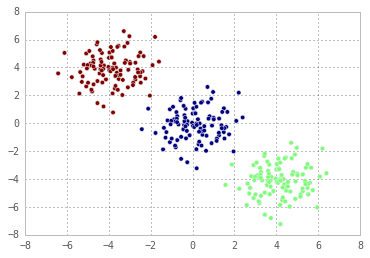

In [209]:
%matplotlib inline
plt.scatter(x[:, 0], x[:, 1], c=y)

In [210]:
def calc_grads(x, pk, m):
    nx = np.zeros((300, 3))
    for i in range(3):
        nx[:, i] = stat.multivariate_normal.pdf(x, mean=m[i], cov=1)

    pxk = nx*pk
    px = np.sum(pxk, axis=1)
    pk_x = pxk / px[:, np.newaxis]

    dpk = np.sum(nx / px[:, np.newaxis], axis=0) / x.shape[0]
    dm = np.zeros((3, 2))
    for i in range(3):
        dm[i] = np.sum(pk_x[:, i:(i+1)] * (x - m[i]), axis=0) / 2.
        
    return dpk, dm, pk_x

In [211]:
# randomly initialize parameters
pk = np.random.rand(3)
pk /= np.sum(pk)

m = np.zeros((3, 2))
m[0, :] = x[np.random.randint(x.shape[0])]
m[1, :] = x[np.random.randint(x.shape[0])]
m[2, :] = x[np.random.randint(x.shape[0])]

# gradient ascent
lr = 1e-2

i = 0
while True:
    i = i + 1
    dpk, dm, pk_x = calc_grads(x, pk, m)
    m += lr * dm
    pk += lr * dpk
    pk /= np.sum(pk)
    if np.sum(np.square(dm)) < 1e-9:
        break

print pk
print m
print "Complete in {0:d} iterations".format(i)

[ 0.33294643  0.33365479  0.33339879]
[[-3.87222539  3.88031092]
 [ 4.12539766 -4.11834281]
 [ 0.12229863 -0.11471626]]
Complete in 143 iterations


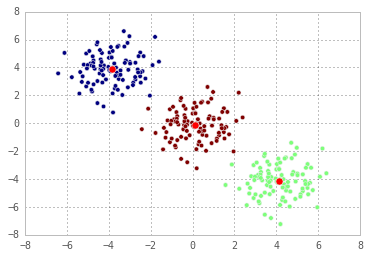

In [212]:
yp = np.argmax(pk_x, axis=1)
plt.scatter(x[:, 0], x[:, 1], c=yp)
plt.scatter(m[:, 0], m[:, 1], s=50, c='red', marker='o')

## Expectation Maximization

As our second method, we look at expectation maximization.

In [222]:
def e_step(x, pk, m):
    nx = np.zeros((300, 3))
    for i in range(3):
        nx[:, i] = stat.multivariate_normal.pdf(x, mean=m[i], cov=1)

    pxk = nx*pk
    px = np.sum(pxk, axis=1)
    pk_x = pxk / px[:, np.newaxis]

    return pk_x

def m_step(x, pk_x):
    pk = np.sum(pk_x, axis=0) / np.sum(pk_x)
    m = np.zeros((3, 2))
    for i in range(3):
        m[i] = np.sum(pk_x[:, i:(i+1)] * x, axis=0) / np.sum(pk_x[:, i:(i+1)])
    return pk, m

In [227]:
# randomly initialize parameters
pk = np.random.rand(3)
pk /= np.sum(pk)

m = np.zeros((3, 2))
m[0, :] = x[np.random.randint(x.shape[0])]
m[1, :] = x[np.random.randint(x.shape[0])]
m[2, :] = x[np.random.randint(x.shape[0])]


i = 0
while True:
    i = i + 1
    old_m = m
    pk_x = e_step(x, pk, m)
    pk, m = m_step(x, pk_x)
    if np.sum(np.square(m - old_m)) < 1e-9:
        break
        
print pk
print m
print "Complete in {0:d} iterations".format(i)

[ 0.333326    0.33262147  0.33405253]
[[ 0.12228373 -0.11469982]
 [-3.87222982  3.88031706]
 [ 4.12538546 -4.11833386]]
Complete in 13 iterations


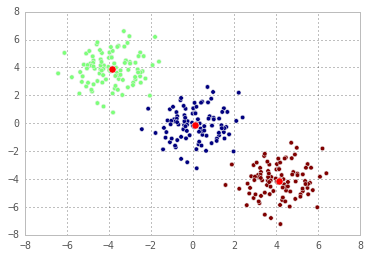

In [228]:
pk_x = e_step(x, pk, m)
yp = np.argmax(pk_x, axis=1)
plt.scatter(x[:, 0], x[:, 1], c=yp)
plt.scatter(m[:, 0], m[:, 1], s=50, c='red', marker='o')